<a href="https://colab.research.google.com/github/jrobledob/AI_in_Plant_Pathology_Fall_2025/blob/main/LogReg_Colab_Plant_Path.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Logistic Regression:




## ML Tasks & Pipeline:

### 1) Quick overview: Classification vs. Regression

- **Classification** → predict a **category/label**.  
  Examples: *Diseased (1) vs Healthy (0)*; *Pathogen species A/B/C*; *Symptom class*.

- **Regression** → predict a **number/quantity**.  
  Examples: lesion length (mm); disease incidence (%); inoculum density.

We use features $\mathbf{x}$ and a model $f(\cdot)$ to produce predictions $\hat{y}$.



### 2) Supervised vs. Unsupervised Learning:

**Supervised learning**
- Inputs: features $\mathbf{x}$ **and** targets $y$ (labels or numbers).
- Goal: learn a mapping $f(\mathbf{x}; \theta) \to \hat{y}$ that generalizes.
- Needs: labeled data; clear metrics (accuracy, ROC–AUC, RMSE).

**Unsupervised learning**
- Inputs: features $\mathbf{x}$ **only** (no labels).
- Goal: discover structure (clusters, low-dim patterns).
- Needs: unlabeled data; internal/qualitative evaluation.

In this notebook, logistic regression is a **supervised classification** method.



## 3) Supervised ML flow:

**Inputs & notation**  
- Feature vector: $\mathbf{x}_i \in \mathbb{R}^d$  
- Target: $y_i$ (class label or real value)  
- Parameters: $\theta$  
- Mapper: $f(\mathbf{x}; \theta)$  
- Prediction: $\hat{y}_i = f(\mathbf{x}_i; \theta)$  
- Loss: $J(\theta)$

**Flow**
1. **Input data** $\rightarrow$ features $\mathbf{x}_i$, target $y_i$  
2. **Feature space** $\rightarrow$ clean/engineer/scale $\mathbf{x}_i \in \mathbb{R}^d$  
3. **Mapper / Model** $\rightarrow$ $\hat{y}_i = f(\mathbf{x}_i; \theta)$  
4. **Compare with target** $\rightarrow$ discrepancy between $\hat{y}_i$ and $y_i$  
5. **Loss / Objective**
$$
J(\theta) = \sum_{i=1}^{N} \ell\big(\hat{y}_i, y_i\big)
$$
6. **Learning algorithm**
$$
\theta \leftarrow \theta - \eta \,\nabla_{\theta} J(\theta)
$$
then loop back to the mapper with updated $\theta$.  
7. **Evaluation & deployment** on held-out data; thresholds; interpretation.


### Supervised Learning Flowchart

<p align="center">
<img src="https://github.com/jrobledob/AI_in_Plant_Pathology_Fall_2025/blob/main/Data/Supervise_Learning_Flowchart.png?raw=true" alt="Supervised Learning Flowchart" width="600"/>
</p>


## 4) The sigmoid and cross-entropy


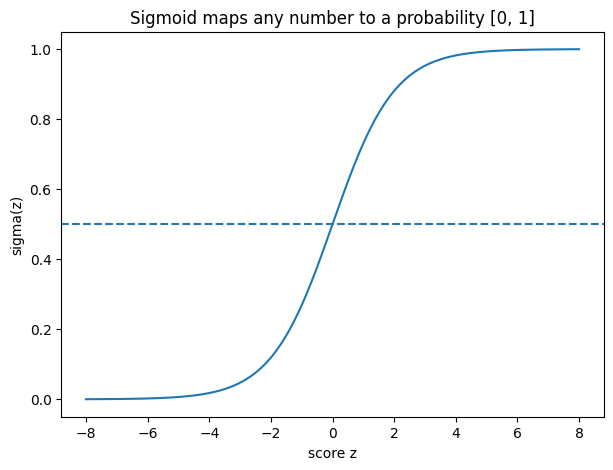

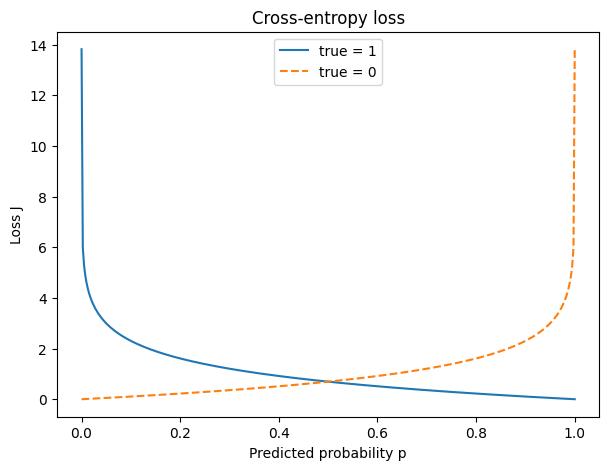

In [1]:

import numpy as np
import matplotlib.pyplot as plt

# Sigmoid
z = np.linspace(-8, 8, 400)
sig = 1/(1+np.exp(-z))
plt.figure(figsize=(7,5))
plt.plot(z, sig)
plt.axhline(0.5, linestyle="--")
plt.xlabel("score z")
plt.ylabel("sigma(z)")
plt.title("Sigmoid maps any number to a probability [0, 1]")
plt.show()

# Cross-entropy
p = np.linspace(1e-6, 1-1e-6, 400)
loss_t1 = -np.log(p)
loss_t0 = -np.log(1-p)
plt.figure(figsize=(7,5))
plt.plot(p, loss_t1, label="true = 1")
plt.plot(p, loss_t0, linestyle="--", label="true = 0")
plt.xlabel("Predicted probability p")
plt.ylabel("Loss J")
plt.title("Cross-entropy loss")
plt.legend()
plt.show()



## 5) Gradient Descent:

We minimize $J(\mathbf{w}, w_0)$ by moving **against** the gradient (downhill).

Useful identities: $\sigma'(z) = \sigma(z)\big(1-\sigma(z)\big)$ and
$$
\frac{\partial J}{\partial z_i} = p_i - t_i.
$$

Vector gradients:
$$
\frac{\partial J}{\partial \mathbf{w}} = \mathbf{X}^{\top}(\mathbf{p}-\mathbf{t}), \qquad
\frac{\partial J}{\partial w_0} = \sum_{i=1}^{N} (p_i - t_i).
$$

Updates with learning rate $\eta$:
$$
\mathbf{w} \leftarrow \mathbf{w} - \eta \,\frac{\partial J}{\partial \mathbf{w}}, \qquad
w_0 \leftarrow w_0 - \eta \,\frac{\partial J}{\partial w_0}.
$$


## Gradient Descent Visualization

<p align="center">
<img src="https://github.com/jrobledob/AI_in_Plant_Pathology_Fall_2025/blob/main/Data/gradient%20descent%20mild.jpeg?raw=true" alt="Gradient Descent Visualization (Mild)" width="600"/>
</p>

<p align="center">
<img src="https://github.com/jrobledob/AI_in_Plant_Pathology_Fall_2025/blob/main/Data/batch-gradient-descent.webp?raw=true" alt="Batch Gradient Descent Visualization" width="600"/>
</p>

/tmp/ipython-input-667340590.py:7: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-z))


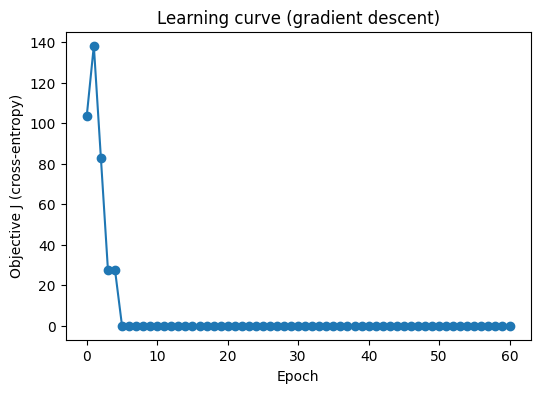

In [6]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

def sigmoid(z):
    return 1/(1+np.exp(-z))

def cross_entropy_loss(w, X, t):
    z = w[0] + X @ w[1:]
    p = sigmoid(z)
    return -(t*np.log(p + 1e-12) + (1-t)*np.log(1-p + 1e-12)).sum()

def gradient(w, X, t):
    z = w[0] + X @ w[1:]
    p = sigmoid(z)
    error = (p - t)
    grad_w = X.T @ error
    grad_b = error.sum()
    return np.r_[grad_b, grad_w]

def fit_logreg_gd_with_history(X, t, eta=0.1, n_epochs=60, random_state=1, snapshot_epochs=(0,5,20,59)):
    rng = np.random.RandomState(random_state)
    w = rng.normal(0, 0.01, size=1 + X.shape[1])
    J_hist = []
    grad_norm_hist = []
    snaps = {}
    for epoch in range(n_epochs):
        J_hist.append(cross_entropy_loss(w, X, t))
        g = gradient(w, X, t)
        grad_norm_hist.append(np.linalg.norm(g))
        if epoch in snapshot_epochs:
            snaps[epoch] = w.copy()
        w = w - eta * g
    # final record
    J_hist.append(cross_entropy_loss(w, X, t))
    grad_norm_hist.append(np.linalg.norm(gradient(w, X, t)))
    snaps[max(snapshot_epochs)+1] = w.copy()
    return w, np.array(J_hist), np.array(grad_norm_hist), snaps

# Data (2 features for plotting)
iris = load_iris()
X = iris.data[:, 2:4].copy()
y = (iris.target == 0).astype(int)
X = StandardScaler().fit_transform(X)

w, J_hist, grad_norm_hist, snaps = fit_logreg_gd_with_history(X, y, eta=10000, n_epochs=60)

# Learning curve
plt.figure(figsize=(6,4))
plt.plot(J_hist, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Objective J (cross-entropy)")
plt.title("Learning curve (gradient descent)")
plt.show()

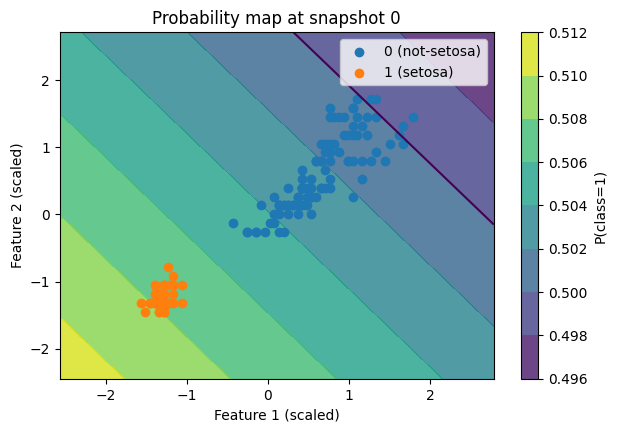

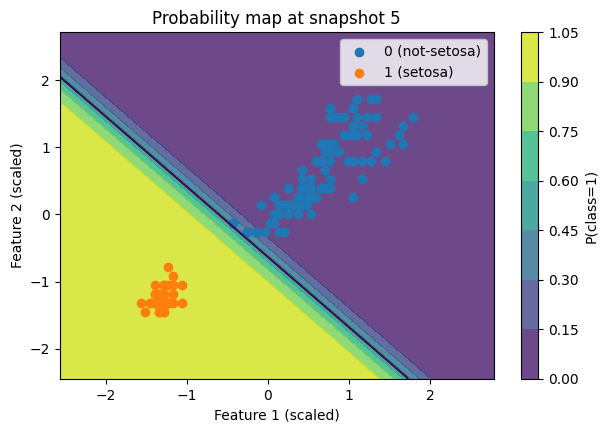

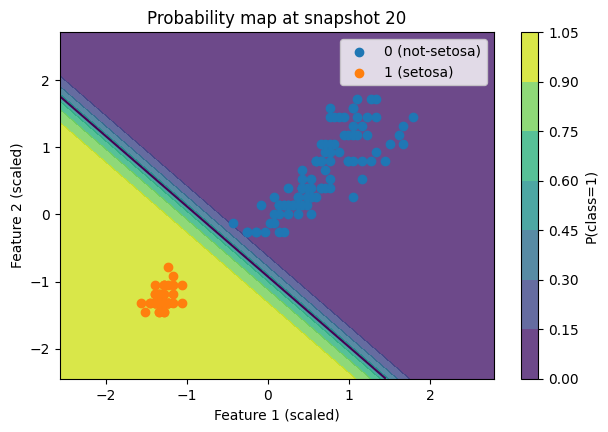

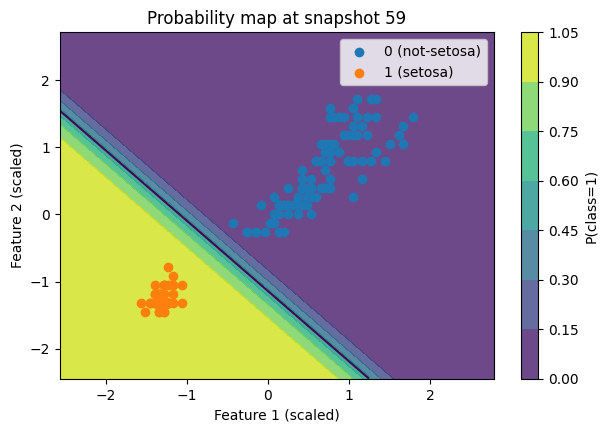

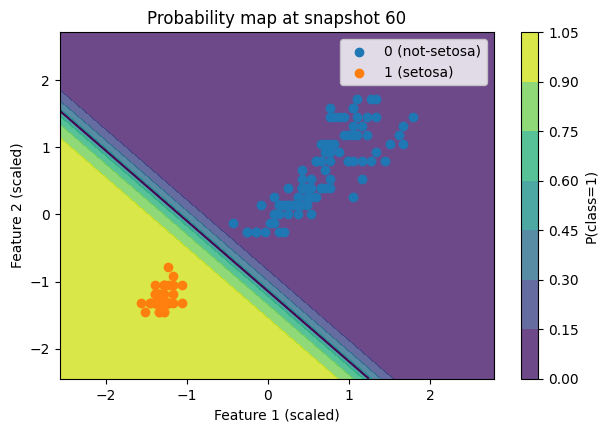

In [3]:

# Probability maps at snapshots
import numpy as np
import matplotlib.pyplot as plt

def plot_prob_map(X, y, w, title="Probability map & decision boundary"):
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    p = 1/(1+np.exp(-(w[0] + grid @ w[1:]))).reshape(xx.shape)
    plt.figure(figsize=(7,4.5))
    cs = plt.contourf(xx, yy, p, alpha=0.8)
    plt.colorbar(cs, label="P(class=1)")
    plt.scatter(X[y==0,0], X[y==0,1], label='0 (not-setosa)')
    plt.scatter(X[y==1,0], X[y==1,1], label='1 (setosa)')
    plt.contour(xx, yy, p, levels=[0.5])
    plt.legend(loc="upper right")
    plt.title(title)
    plt.xlabel("Feature 1 (scaled)")
    plt.ylabel("Feature 2 (scaled)")
    plt.show()

for ep in sorted(snaps.keys()):
    plot_prob_map(X, y, snaps[ep], title=f"Probability map at snapshot {ep}")



## 7) Binary training with scikit-learn + metrics


Train acc: 1.0
Test  acc: 1.0
Intercept: [-8.38139688]
Coeffs: [[-8.39450843 -5.24106522]]


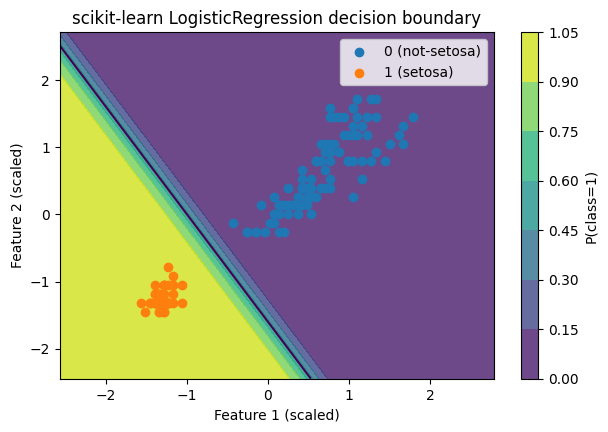

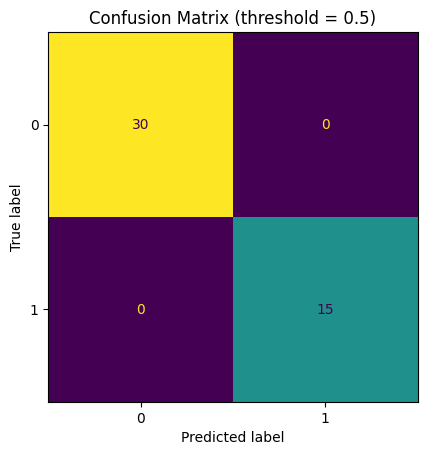

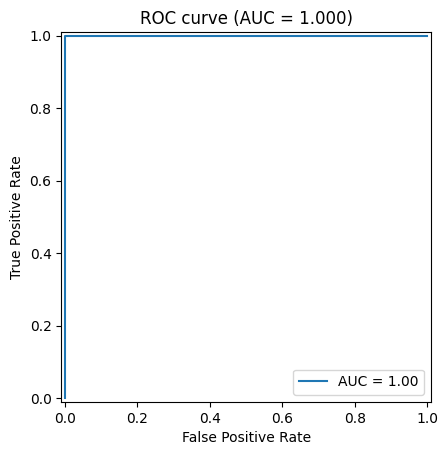

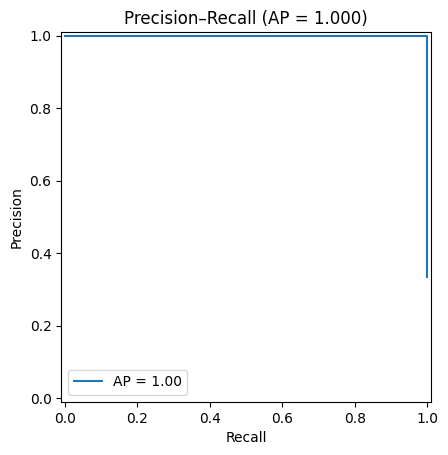

In [4]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             roc_curve, auc, precision_recall_curve,
                             average_precision_score, RocCurveDisplay,
                             PrecisionRecallDisplay)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

clf = LogisticRegression(penalty=None, solver="lbfgs", max_iter=500, random_state=42)
clf.fit(Xtr, ytr)
print("Train acc:", clf.score(Xtr, ytr))
print("Test  acc:", clf.score(Xte, yte))
print("Intercept:", clf.intercept_)
print("Coeffs:", clf.coef_)

# Decision boundary (reuse plot function via w vector)
w_skl = np.r_[clf.intercept_[0], clf.coef_[0]]
plot_prob_map(X, y, w_skl, title="scikit-learn LogisticRegression decision boundary")

# Confusion Matrix at 0.5
yproba_te = clf.predict_proba(Xte)[:,1]
ypred_te  = (yproba_te >= 0.5).astype(int)
cm = confusion_matrix(yte, ypred_te, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(colorbar=False)
plt.title("Confusion Matrix (threshold = 0.5)")
plt.show()

# ROC
fpr, tpr, _ = roc_curve(yte, yproba_te)
roc_auc = auc(fpr, tpr)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.title(f"ROC curve (AUC = {roc_auc:.3f})")
plt.show()

# Precision–Recall
prec, rec, _ = precision_recall_curve(yte, yproba_te)
ap = average_precision_score(yte, yproba_te)
PrecisionRecallDisplay(precision=prec, recall=rec, average_precision=ap).plot()
plt.title(f"Precision–Recall (AP = {ap:.3f})")
plt.show()



## 8) Multiclass logistic regression (with performance metrics)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Multiclass Train acc: 0.9809523809523809
Multiclass Test  acc: 0.9111111111111111


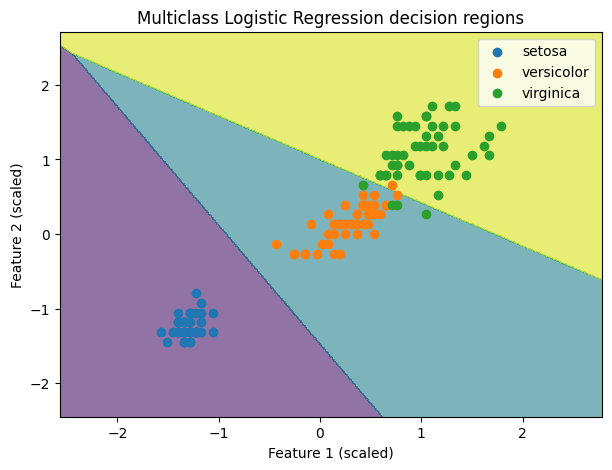

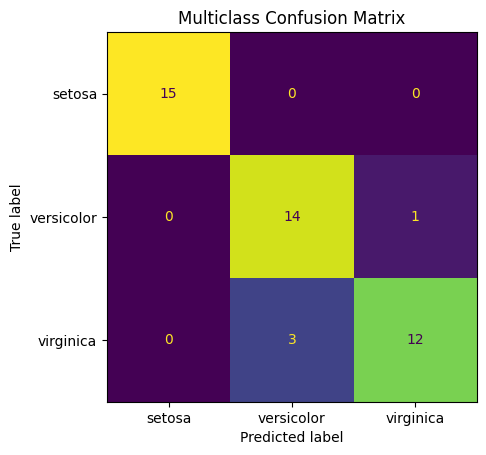

Classification report:

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.82      0.93      0.88        15
   virginica       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45



In [5]:

from sklearn.metrics import classification_report
from matplotlib.colors import ListedColormap

X_multi = iris.data[:, 2:4].copy()
y_multi = iris.target.copy()
X_multi = StandardScaler().fit_transform(X_multi)

Xtr_m, Xte_m, ytr_m, yte_m = train_test_split(X_multi, y_multi, test_size=0.3, random_state=42, stratify=y_multi)

clf_multi = LogisticRegression(multi_class="multinomial", penalty="l2",
                               C=1.0, solver="lbfgs", max_iter=500, random_state=42)
clf_multi.fit(Xtr_m, ytr_m)

print("Multiclass Train acc:", clf_multi.score(Xtr_m, ytr_m))
print("Multiclass Test  acc:", clf_multi.score(Xte_m, yte_m))

# Decision regions
x_min, x_max = X_multi[:,0].min()-1, X_multi[:,0].max()+1
y_min, y_max = X_multi[:,1].min()-1, X_multi[:,1].max()+1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                     np.linspace(y_min, y_max, 400))
grid = np.c_[xx.ravel(), yy.ravel()]
pred = clf_multi.predict(grid).reshape(xx.shape)

plt.figure(figsize=(7,5))
plt.contourf(xx, yy, pred, alpha=0.6)
for k, name in enumerate(iris.target_names):
    plt.scatter(X_multi[y_multi==k,0], X_multi[y_multi==k,1], label=name)
plt.legend()
plt.title("Multiclass Logistic Regression decision regions")
plt.xlabel("Feature 1 (scaled)"); plt.ylabel("Feature 2 (scaled)")
plt.show()

# Performance metrics
y_pred_m = clf_multi.predict(Xte_m)
cm_m = confusion_matrix(yte_m, y_pred_m)
disp_m = ConfusionMatrixDisplay(confusion_matrix=cm_m, display_labels=iris.target_names)
disp_m.plot(colorbar=False)
plt.title("Multiclass Confusion Matrix")
plt.show()

print("Classification report:\n")
print(classification_report(yte_m, y_pred_m, target_names=iris.target_names))



## 9) Practical checklist for plant pathology projects ✅

- Define the question (screening vs confirmation → threshold choice).  
- Split train/test (and consider cross-validation).  
- Scale features if magnitudes vary widely.  
- Watch class imbalance → `class_weight='balanced'` or resampling.  
- Inspect confusion matrix, ROC–AUC/PR (binary) and per-class precision/recall/F1 (multiclass).  
- Use regularization (`penalty`, `C`) to avoid overfitting.  
- Prefer scikit-learn for robust fitting; custom GD for teaching/demos.  
- Communicate probabilities and align with decision costs.


## 9) Logistic Regression through the flowchart

**Task:** binary or multiclass classification; **Features:** $\mathbf{x}_i \in \mathbb{R}^d$

### 9.1 Mapper / Model

**Binary (diseased vs healthy)**  
Score and probability:
$$
z_i = w_0 + \mathbf{w}^{\top}\mathbf{x}_i, \qquad
p_i = \Pr(y_i=1 \mid \mathbf{x}_i) = \sigma(z_i) = \frac{1}{1 + e^{-z_i}}.
$$
Prediction at threshold $\tau$:
$$
\hat{y}_i = 1\{\,p_i \ge \tau\,\}.
$$

**Multiclass (softmax), $k=1,\dots,K$**
$$
p_i^{(k)} = \Pr(y_i=k \mid \mathbf{x}_i) =
\frac{\exp\!\big(\mathbf{w}_k^{\top}\mathbf{x}_i + w_{0,k}\big)}{\sum_{j=1}^{K} \exp\!\big(\mathbf{w}_j^{\top}\mathbf{x}_i + w_{0,j}\big)},
\qquad
\hat{y}_i = \arg\max_{k} \, p_i^{(k)}.
$$

### 9.2 Compare with target
Binary target $t_i \in \{0,1\}$ or multiclass $t_i \in \{1,\dots,K\}$.

### 9.3 Loss / Objective

**Binary cross-entropy**
$$
J(\mathbf{w}, w_0) = -\sum_{i=1}^{N}\big[t_i \log p_i + (1 - t_i)\log(1 - p_i)\big].
$$

**Multinomial (softmax) cross-entropy**
$$
J\big(\{\mathbf{w}_k, w_{0,k}\}\big) =
-\sum_{i=1}^{N}\sum_{k=1}^{K} 1\{t_i = k\}\,\log\!\big(p_i^{(k)}\big).
$$

### 9.4 Learning algorithm (optimization)

For the binary case (vector form):
$$
\frac{\partial J}{\partial \mathbf{w}} = \mathbf{X}^{\top}(\mathbf{p}-\mathbf{t}), \qquad
\frac{\partial J}{\partial w_0} = \sum_{i=1}^{N} (p_i - t_i).
$$
Update with learning rate $\eta$:
$$
\mathbf{w} \leftarrow \mathbf{w} - \eta \,\frac{\partial J}{\partial \mathbf{w}}, \qquad
w_0 \leftarrow w_0 - \eta \,\frac{\partial J}{\partial w_0}.
$$

### 9.5 Evaluation
Binary: confusion matrix, ROC–AUC, precision–recall; Multiclass: per-class precision/recall/F1 and confusion matrix.


### Exercise: Complete the flowchart with the components of logistic regression

<p align="center">
<img src="https://github.com/jrobledob/AI_in_Plant_Pathology_Fall_2025/blob/main/Data/Supervise_Learning_Flowchart.png?raw=true" alt="Supervised Learning Flowchart" width="600"/>
</p>